In [1]:
import nest_asyncio
nest_asyncio.apply()

In [2]:
import nest_asyncio
nest_asyncio.apply()
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from tensorflow import reshape, nest, config
from tensorflow.keras.datasets import mnist
import pandas as pd
from random import sample
from matplotlib import pyplot as plt
from sklearn import preprocessing
from uuid import uuid4
import pickle
np.random.seed(0)

In [3]:
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack import membership_inference_attack as mia
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackInputData
from tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.data_structures import AttackType

# Set up data

In [22]:
datapath = '/ssd003/projects/pets/application_train.csv'
raw_train = pd.read_csv(datapath)
raw_train

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,456251,0,Cash loans,M,N,N,0,157500.0,254700.0,27558.0,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307507,456252,0,Cash loans,F,N,Y,0,72000.0,269550.0,12001.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
307508,456253,0,Cash loans,F,N,Y,0,153000.0,677664.0,29979.0,...,0,0,0,0,1.0,0.0,0.0,1.0,0.0,1.0
307509,456254,1,Cash loans,F,N,Y,0,171000.0,370107.0,20205.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


# Preprocessing Function

In [23]:
def data_preprocessing(df):
    target = 'TARGET'
    id_col = 'SK_ID_CURR'

    #Delete target column as it is not useful for prediction
    del df[id_col]

    #Distribution of target variable
    df[target].value_counts()

    #Store target variable to be used later
    target_val = df[target]

    #Delete target column from features
    target_col = df.pop(target)

    # Write UID
    uid_col = pd.Series([uuid4() for _ in range(len(df))])

    # Get all continuous variabels 
    cont_vars = []
    for col in df.columns:
        if df[col].dtype == 'int64' or df[col].dtype == 'float64':
            cont_vars.append(col)

    #Store number of continous variable. This will be equivalent to number of neurons in input layer
    cont_train = df.loc[:, cont_vars]
    curr_dim = cont_train.shape[1]
    
    #Fill NAs with mean value of column. Lot of scope of improvement here :)
    cont_train = cont_train.fillna(cont_train.mean())

    #Normalize features using standard scaler. We will use same standard scaler object to normalize test data
    std_scale = preprocessing.StandardScaler().fit(cont_train[cont_vars])
    cont_train[cont_vars] = std_scale.transform(cont_train[cont_vars])
    
    # Extract home credit subdataset
    home_credit_cols = [col for col in cont_train.columns if "credit_bureau" not in str.lower(col)]
    home_credit_df = cont_train[home_credit_cols].copy()
    home_credit_df["target"] = target_col
    return home_credit_df

# Set up partitions

In [24]:
positive_class = raw_train[raw_train.TARGET == 1]
negative_class = raw_train[raw_train.TARGET == 0]
(len(positive_class), len(negative_class))

(24825, 282686)

In [25]:
n_positive = 600
n_negative = 1400
(n_positive, n_negative, n_positive + n_negative, n_positive/(n_positive + n_negative))

(600, 1400, 2000, 0.3)

In [26]:
pos_sizes = np.cumsum([n_positive, n_positive, n_positive, n_positive])
pos_dfs = np.array_split(positive_class.sample(frac=1), pos_sizes)
print([len(d) for d in pos_dfs])

[600, 600, 600, 600, 22425]


In [27]:
neg_sizes = np.cumsum([n_negative, n_negative, n_negative, n_negative])
neg_dfs = np.array_split(negative_class.sample(frac=1), neg_sizes)
print([len(d) for d in neg_dfs])

[1400, 1400, 1400, 1400, 277086]


In [28]:
#sizes = np.cumsum([10000, 10000, 10000, 10000])
#dfs = np.array_split(raw_train.sample(frac=1), sizes)
#print([len(d) for d in dfs])

In [29]:
data1 = data_preprocessing(pd.concat([pos_dfs[0], neg_dfs[0]]).sample(frac=1))
data1['hospital_id'] = 1

data2 = data_preprocessing(pd.concat([pos_dfs[1], neg_dfs[1]]).sample(frac=1))
data2['hospital_id'] = 2

data3 = data_preprocessing(pd.concat([pos_dfs[2], neg_dfs[2]]).sample(frac=1))
data3['hospital_id'] = 3

data4 = data_preprocessing(pd.concat([pos_dfs[3], neg_dfs[3]]).sample(frac=1))
data4['hospital_id'] = 4

In [30]:
print(len(data1)) 
print(data1.target.value_counts(normalize=True))
print(len(data2)) 
print(data2.target.value_counts(normalize=True))
print(len(data3)) 
print(data3.target.value_counts(normalize=True))
print(len(data4)) 
print(data4.target.value_counts(normalize=True))

2000
0    0.7
1    0.3
Name: target, dtype: float64
2000
0    0.7
1    0.3
Name: target, dtype: float64
2000
0    0.7
1    0.3
Name: target, dtype: float64
2000
0    0.7
1    0.3
Name: target, dtype: float64


# Combine and format DataFrame

In [31]:
data = pd.concat([data1, data2, data3, data4])

In [6]:
#pickle.dump(data, open("data_dp.pkl.gz",'wb'))

import pickle

data = pickle.load(open("data_dp.pkl.gz",'rb'))

In [32]:
df = data
new = df.copy()
del new['target']
data['features']= new.values.tolist()

#data['hospital_id'] = np.random.randint(1,5, size=len(data))
data = data[['target', 'hospital_id', 'features']]
data.index = range(len(data))

In [33]:
data.head()

,target,hospital_id,features
0,1,1,"[-0.5902056841822938, -0.8531326517816321, -0...."
1,0,1,"[-0.5902056841822938, 0.11317836032041487, -1...."
2,1,1,"[0.7619264674380815, 2.5289558905755323, -1.04..."
3,1,1,"[0.7619264674380815, -1.0288255630729133, -1.1..."
4,0,1,"[-0.5902056841822938, -0.10643777879368672, 2...."


In [34]:
data.shape

(8000, 3)

In [35]:
data.hospital_id.value_counts()

3    2000
2    2000
1    2000
4    2000
Name: hospital_id, dtype: int64

# Number of features

In [36]:
n_features = len(data['features'][0])
n_features

99

# Set up the sets of ids

In [37]:
client_id_colname = 'hospital_id' #column that represents client ID 
number_of_training_clients = 3

train_client_ids = [1,2,3]
test_client_ids = [4]

# Create some TF datasets

In [38]:
SHUFFLE_BUFFER = 1000
NUM_EPOCHS = 10

def create_tf_dataset_for_client_fn(client_id):
    client_data = data[data[client_id_colname] == client_id]
    dataset = tf.data.Dataset.from_tensor_slices(client_data.to_dict('list'))
    dataset = dataset.shuffle(SHUFFLE_BUFFER).batch(1).repeat(NUM_EPOCHS)
    return dataset

In [39]:
train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=train_client_ids, 
    serializable_dataset_fn=create_tf_dataset_for_client_fn)

test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=test_client_ids,
    serializable_dataset_fn=create_tf_dataset_for_client_fn)

# Batch preprocessing function

In [40]:
NUM_EPOCHS = 10
BATCH_SIZE = 5000
PREFETCH_BUFFER = 2500
def preprocess(dataset):
    def batch_format_fn(element):    
        return collections.OrderedDict(x=tf.reshape(element['features'], [-1,n_features]),
                                       y=tf.reshape(element['target'], [-1,1]))

    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(
      BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [41]:
example_dataset = train_data.create_tf_dataset_for_client(
        train_data.client_ids[2]
    )
print(example_dataset)
example_element = iter(example_dataset).next()
print(example_element)

<RepeatDataset element_spec={'target': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'hospital_id': TensorSpec(shape=(None,), dtype=tf.int32, name=None), 'features': TensorSpec(shape=(None, 99), dtype=tf.float32, name=None)}>
{'target': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0], dtype=int32)>, 'hospital_id': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([3], dtype=int32)>, 'features': <tf.Tensor: shape=(1, 99), dtype=float32, numpy=
array([[ 2.0896881e+00,  6.7803150e-01,  5.4496855e-01, -3.9980266e-02,
         4.0075162e-01,  3.2719278e-01,  1.2564211e+00, -4.4662514e-01,
         6.7658782e-01,  8.0221093e-01, -5.2292617e-16,  0.0000000e+00,
         4.5256963e-01, -5.2023846e-01,  3.1638600e-02,  1.6055583e+00,
        -2.5929877e-01,  9.0724093e-01, -1.5184589e-01, -1.0262146e-01,
        -4.7081208e-04, -1.2952535e-01, -2.3657179e-01, -2.0938323e-01,
        -2.8679448e-01, -5.6349182e-01, -4.8668098e-01,  1.0388881e+00,
         8.4289658e-01, -4.6027464e-0

In [42]:
preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(),
                                     next(iter(preprocessed_example_dataset)))

sample_batch

OrderedDict([('x',
              array([[-0.5613593 ,  0.26219508,  1.1903484 , ...,  0.        ,
                       0.        ,  3.        ],
                     [-0.5613593 , -0.56947774, -0.84249675, ...,  0.        ,
                       0.        ,  3.        ],
                     [ 0.7641644 , -0.36155954, -0.37641662, ...,  0.        ,
                       0.        ,  3.        ],
                     ...,
                     [-0.5613593 , -0.62145734, -0.59309113, ...,  0.        ,
                       0.        ,  3.        ],
                     [-0.5613593 , -0.10166179,  0.8797185 , ...,  0.        ,
                       0.        ,  3.        ],
                     [-0.5613593 , -1.1412529 , -0.38831884, ...,  0.        ,
                       0.        ,  3.        ]], dtype=float32)),
             ('y',
              array([[0],
                     [0],
                     [1],
                     ...,
                     [0],
                    

In [43]:
sample_batch['x'].shape

(5000, 99)

# Federated data preprocessing

In [48]:
def make_federated_data(client_data, client_ids):
    return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
    ]

# Keras model

In [49]:
def create_keras_model():
    return tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(n_features,), name='x'), # n_features
      tf.keras.layers.Dense(150, activation = 'swish'),
        tf.keras.layers.Dense(50, activation = 'swish'),
        tf.keras.layers.Dense(1, activation = 'sigmoid'),
      ])

In [50]:
import tensorflow_addons as tfa

def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
    keras_model = create_keras_model()
    return tff.learning.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.BinaryCrossentropy(),
      metrics=[tf.keras.metrics.BinaryAccuracy(), tf.keras.metrics.Precision(name='Precision'),
               tf.keras.metrics.Recall(name='Recall'), tf.keras.metrics.AUC(name='AUC')])

# Training Loop

In [51]:
evaluation = tff.learning.build_federated_evaluation(model_fn)

In [52]:
def training_loop(federated_train_data, federated_test_data, iterative_process, NUM_ROUNDS):
    
    list_metrics = []
    list_val_metrics = []

    state = iterative_process.initialize()

    for round_num in range(1, NUM_ROUNDS+1):
        state, metrics = iterative_process.next(state, federated_train_data)
        val_metrics = evaluation(state.model, federated_test_data)

        list_metrics.append(metrics)
        list_val_metrics.append(val_metrics)
        
        print()
        print(pd.concat([
            pd.DataFrame([list_val_metrics[i]['eval'] for i in range(len(list_val_metrics))]),
            pd.DataFrame([list_metrics[i]['train'] for i in range(len(list_metrics))]),
        ], axis=1))

    return {
        'state':state,
        'training':list_metrics,
        'eval':list_val_metrics,
    }

# Federated (three clients)

In [53]:
%%time
results_fed = {}

train_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=[1,2,3], 
    serializable_dataset_fn=create_tf_dataset_for_client_fn)

test_data = tff.simulation.datasets.ClientData.from_clients_and_tf_fn(
    client_ids=[4],
    serializable_dataset_fn=create_tf_dataset_for_client_fn)

federated_train_data = make_federated_data(train_data, [1,2,3])
federated_test_data = make_federated_data(test_data, [4])


for multiplier in [0.0, 0.1, 0.2, 0.3]:
    print(multiplier)

    noise_multiplier = multiplier
    clients_per_round = 3
    aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
          noise_multiplier, clients_per_round)
    
    iterative_process = tff.learning.build_federated_averaging_process(
        model_fn,
        client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.2),
        server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.2),
        model_update_aggregation_factory=aggregation_factory)

    result = training_loop(federated_train_data, federated_test_data, iterative_process, 100)
    results_fed[multiplier] = result

0.0
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`


Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`



   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0           0.6505   0.393548   0.305  0.602021  0.645424         0.716293   

   Precision    Recall       AUC      loss  
0   0.612653  0.147683  0.690993  0.564998  

   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0           0.6505   0.393548   0.305  0.602021  0.645424         0.716293   
1           0.6640   0.413043   0.285  0.608204  0.640482         0.717617   

   Precision    Recall       AUC      loss  
0   0.612653  0.147683  0.690993  0.564998  
1   0.620021  0.151678  0.693596  0.563597  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1           0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2           0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   

   Precision    Recall       AUC      loss  
0   0.612653  


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
5            0.6995   0.497835  0.191667  0.635756  0.617874         0.722367   
6            0.7030   0.514852  0.173333  0.642342  0.611662         0.723620   
7            0.7020   0.511236  0.151667  0.648760  0.605324         0.724903   
8            0.7075   0.548387  0.141667  0.655167  0.598959         0.725912   
9            0.7070   0.548611  0.131667  0.661074  0.592683         0.727288   
10           0.7110   0.582090  0.130000  0.666458  0.586634         0.728465   
11           0.7130   0.606


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
..              ...        ...       ...       ...       ...              ...   
56           0.7115   0.553991  0.196667  0.693495  0.603413         0.768545   
57           0.7125   0.558140  0.200000  0.693022  0.604084         0.769032   
58           0.7125   0.557604  0.201667  0.692523  0.605101         0.769690   
59           0.7125   0.557604  0.201667  0.692006  0.606078         0.770198   
60           0.7110   0.549107  0.205000  0.691446  0.606566         0.770740   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
..              ...        ...       ...       ...       ...              ...   
62           0.7140   0.559322  0.220000  0.690091  0.607979         0.771873   
63           0.7150   0.563025  0.223333  0.689494  0.609034         0.772627   
64           0.7135   0.555556  0.225000  0.688643  0.610054         0.773258   
65           0.7155   0.561265  0.236667  0.687960  0.609972         0.774028   
66           0.7140   0.557851  0.225000  0.687561  0.613708         0.774895   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
..              ...        ...       ...       ...       ...              ...   
68           0.7130   0.550388  0.236667  0.686446  0.615120         0.775600   
69           0.7140   0.557377  0.226667  0.685970  0.618901         0.775482   
70           0.7155   0.558491  0.246667  0.685107  0.616225         0.775980   
71           0.7145   0.555985  0.240000  0.684390  0.619453         0.777138   
72           0.7135   0.551724  0.240000  0.683751  0.620757         0.778512   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
..              ...        ...       ...       ...       ...              ...   
74           0.7135   0.552529  0.236667  0.682105  0.624415         0.778625   
75           0.7145   0.554307  0.246667  0.681393  0.625118         0.779567   
76           0.7130   0.550388  0.236667  0.680914  0.627601         0.779660   
77           0.7130   0.549242  0.241667  0.680152  0.628461         0.780338   
78           0.7125   0.547170  0.241667  0.680073  0.630653         0.780895   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
..              ...        ...       ...       ...       ...              ...   
80           0.7145   0.552727  0.253333  0.678674  0.631746         0.781708   
81           0.7130   0.546099  0.256667  0.678050  0.632269         0.782730   
82           0.7110   0.536184  0.271667  0.677298  0.630734         0.782775   
83           0.7090   0.530000  0.265000  0.676469  0.632793         0.783813   
84           0.7115   0.536977  0.278333  0.676279  0.631520         0.783960   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
..              ...        ...       ...       ...       ...              ...   
86           0.7115   0.536508  0.281667  0.675185  0.633773         0.784460   
87           0.7125   0.538700  0.290000  0.674702  0.634553         0.785860   
88           0.7085   0.525680  0.290000  0.674227  0.634534         0.784388   
89           0.7105   0.532508  0.286667  0.673841  0.637614         0.787455   
90           0.7055   0.515850  0.298333  0.673142  0.637910         0.786105   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6505   0.393548  0.305000  0.602021  0.645424         0.716293   
1            0.6640   0.413043  0.285000  0.608204  0.640482         0.717617   
2            0.6755   0.431755  0.258333  0.614756  0.635235         0.718565   
3            0.6810   0.439873  0.231667  0.621349  0.629702         0.719875   
4            0.6895   0.460967  0.206667  0.628396  0.623908         0.721030   
..              ...        ...       ...       ...       ...              ...   
92           0.7065   0.519062  0.295000  0.672130  0.641047         0.787677   
93           0.7060   0.517544  0.295000  0.671881  0.642787         0.787565   
94           0.7065   0.519288  0.291667  0.671038  0.645839         0.788110   
95           0.7070   0.521084  0.288333  0.670677  0.646897         0.789277   
96           0.7095   0.529412  0.285000  0.670643  0.647921         0.789407   

    Precision    Recall   


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1           0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2           0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3           0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4           0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5           0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   

   Precision    Recall       AUC      loss  
0   0.616426  0.104244  0.686263  0.568648  
1   0.622406  0.107628  0.688846  0.567312  
2   0.628868  0.111561  0.691702  0.565866  
3   0.633477  0.117028  0.694779  0.564192  
4   0.638762  0.122383  0.698113  0.562419  
5   0.644486  0.128872  0.701283  0.560606  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.6605   0.388732  0.230000  0


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
5            0.6940   0.469697  0.155000  0.621912  0.631886         0.717335   
6            0.7005   0.502924  0.143333  0.629603  0.626082         0.718498   
7            0.7020   0.513158  0.130000  0.636752  0.619474         0.719940   
8            0.7075   0.558140  0.120000  0.643340  0.613201         0.721328   
9            0.7065   0.552000  0.115000  0.650410  0.606415         0.722582   
10           0.7100   0.583333  0.116667  0.655899  0.600546         0.724112   
11           0.7090   0.576


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
..              ...        ...       ...       ...       ...              ...   
56           0.7065   0.520505  0.275000  0.681168  0.594806         0.765945   
57           0.7065   0.521036  0.268333  0.681498  0.596632         0.766470   
58           0.7060   0.519231  0.270000  0.680936  0.598160         0.767593   
59           0.7080   0.525641  0.273333  0.681098  0.599694         0.768448   
60           0.7080   0.525974  0.270000  0.680386  0.600846         0.769412   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
..              ...        ...       ...       ...       ...              ...   
62           0.7065   0.519878  0.283333  0.681321  0.601423         0.771315   
63           0.7060   0.517045  0.303333  0.680417  0.599993         0.772212   
64           0.7035   0.509485  0.313333  0.678578  0.603335         0.773808   
65           0.7050   0.513661  0.313333  0.678288  0.604231         0.773773   
66           0.7040   0.510471  0.325000  0.676561  0.606761         0.774758   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
..              ...        ...       ...       ...       ...              ...   
68           0.7040   0.510989  0.310000  0.675880  0.608800         0.774415   
69           0.7045   0.512821  0.300000  0.675206  0.610134         0.775240   
70           0.7070   0.520710  0.293333  0.674492  0.612124         0.775072   
71           0.7070   0.519886  0.305000  0.673641  0.614386         0.775515   
72           0.7090   0.525862  0.305000  0.674168  0.616104         0.776593   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
..              ...        ...       ...       ...       ...              ...   
74           0.7020   0.505405  0.311667  0.671039  0.618352         0.777613   
75           0.7040   0.511236  0.303333  0.669437  0.622033         0.777553   
76           0.7035   0.510204  0.291667  0.668172  0.623498         0.777855   
77           0.7010   0.502825  0.296667  0.667715  0.623154         0.779705   
78           0.7030   0.507772  0.326667  0.667100  0.623163         0.779208   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
..              ...        ...       ...       ...       ...              ...   
80           0.7020   0.504951  0.340000  0.665785  0.631896         0.780108   
81           0.6980   0.495122  0.338333  0.664923  0.634065         0.780810   
82           0.7015   0.503937  0.320000  0.664084  0.634930         0.781543   
83           0.7030   0.507692  0.330000  0.662789  0.637991         0.782598   
84           0.7025   0.506234  0.338333  0.664764  0.638118         0.783010   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
..              ...        ...       ...       ...       ...              ...   
86           0.6975   0.493766  0.330000  0.663613  0.643423         0.783467   
87           0.6990   0.497642  0.351667  0.660310  0.643094         0.783985   
88           0.6985   0.496471  0.351667  0.659528  0.648917         0.784143   
89           0.6945   0.487414  0.355000  0.659271  0.648839         0.785337   
90           0.6880   0.474138  0.366667  0.658768  0.651988         0.785833   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.6605   0.388732  0.230000  0.581517  0.656997         0.711813   
1            0.6680   0.400000  0.213333  0.589447  0.652689         0.712700   
2            0.6760   0.416667  0.200000  0.597479  0.648297         0.713717   
3            0.6845   0.436214  0.176667  0.606236  0.642713         0.714795   
4            0.6915   0.461883  0.171667  0.614508  0.637797         0.715952   
..              ...        ...       ...       ...       ...              ...   
92           0.6910   0.480263  0.365000  0.660923  0.652383         0.786767   
93           0.6885   0.475269  0.368333  0.660671  0.652640         0.787658   
94           0.6925   0.483370  0.363333  0.658792  0.656298         0.788842   
95           0.6945   0.487696  0.363333  0.654450  0.658784         0.788802   
96           0.6940   0.486047  0.348333  0.652968  0.661906         0.789850   

    Precision    Recall   


   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1           0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2           0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3           0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4           0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5           0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   

   Precision    Recall       AUC      loss  
0   0.565219  0.119478  0.668957  0.575799  
1   0.579696  0.122544  0.672253  0.574293  
2   0.589539  0.126672  0.675432  0.572704  
3   0.601408  0.132894  0.679564  0.570572  
4   0.611388  0.136244  0.683042  0.568823  
5   0.619328  0.142772  0.687154  0.566748  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5345   0.302270  0.421667  0


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
5            0.6500   0.353801  0.201667  0.558177  0.654918         0.716505   
6            0.6635   0.384127  0.201667  0.572506  0.649173         0.718270   
7            0.6775   0.418773  0.193333  0.587717  0.642106         0.719490   
8            0.6805   0.417021  0.163333  0.599514  0.633868         0.720938   
9            0.6855   0.418079  0.123333  0.607770  0.623820         0.722458   
10           0.6910   0.445783  0.123333  0.618348  0.615800         0.724577   
11           0.6945   0.467


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
..              ...        ...       ...       ...       ...              ...   
68           0.7040   0.513158  0.260000  0.675046  0.645013         0.772582   
69           0.7075   0.522936  0.285000  0.674939  0.634981         0.772195   
70           0.7020   0.506536  0.258333  0.671821  0.635555         0.774402   
71           0.6985   0.495146  0.255000  0.668478  0.636117         0.774205   
72           0.7070   0.522581  0.270000  0.670465  0.637824         0.775583   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
..              ...        ...       ...       ...       ...              ...   
74           0.6940   0.486111  0.350000  0.670135  0.628407         0.776010   
75           0.6965   0.491049  0.320000  0.669282  0.636325         0.776772   
76           0.7015   0.503856  0.326667  0.670283  0.636721         0.777540   
77           0.7045   0.511811  0.325000  0.667973  0.633376         0.778883   
78           0.7030   0.507853  0.323333  0.666059  0.637568         0.780623   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
..              ...        ...       ...       ...       ...              ...   
80           0.7010   0.502451  0.341667  0.661715  0.651720         0.780615   
81           0.6960   0.491903  0.405000  0.661203  0.651542         0.780448   
82           0.6785   0.461261  0.426667  0.656510  0.662481         0.781587   
83           0.6830   0.468284  0.418333  0.661503  0.661297         0.782123   
84           0.6755   0.454545  0.408333  0.662502  0.665535         0.783513   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
..              ...        ...       ...       ...       ...              ...   
86           0.6595   0.432612  0.433333  0.655692  0.678507         0.784110   
87           0.6695   0.448393  0.441667  0.655934  0.678699         0.784167   
88           0.6785   0.462738  0.445000  0.660008  0.680845         0.785167   
89           0.6750   0.456140  0.433333  0.651904  0.677517         0.785862   
90           0.6715   0.450435  0.431667  0.656886  0.683240         0.785288   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5345   0.302270  0.421667  0.502288  0.690827         0.708272   
1            0.5535   0.307995  0.391667  0.509388  0.685937         0.710108   
2            0.5865   0.321821  0.341667  0.523646  0.678317         0.711543   
3            0.6070   0.326493  0.291667  0.534532  0.671410         0.713445   
4            0.6350   0.345972  0.243333  0.548040  0.662837         0.714893   
..              ...        ...       ...       ...       ...              ...   
92           0.6785   0.459357  0.405000  0.655311  0.699775         0.787893   
93           0.6810   0.464552  0.415000  0.656064  0.714943         0.788895   
94           0.6795   0.462247  0.418333  0.654303  0.708266         0.788067   
95           0.6620   0.438907  0.455000  0.647644  0.717780         0.789493   
96           0.6695   0.446957  0.428333  0.645199  0.711170         0.788312   

    Precision    Recall   

/ssd003/projects/aieng/public/pets_unified/lib/python3.8/site-packages/tensorflow_federated/python/aggregators/differential_privacy.py:75: UserWarning: A significant amount of noise (45661798.34x) has to be added for record aggregation to achieve the desired effective `noise_multiplier` (0.3). If you are manually specifying `clipped_count_stddev` you may want to increase it. Or you may need more `expected_clients_per_round`.
  warnings.warn(



   binary_accuracy  Precision  Recall       AUC      loss  binary_accuracy  \
0           0.5575   0.312253   0.395  0.511071  6.801604         0.709463   

   Precision    Recall       AUC      loss  
0   0.575189  0.120656  0.681789  0.569552  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1           0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   

   Precision    Recall       AUC      loss  
0   0.575189  0.120656  0.681789  0.569552  
1   0.329712  0.438333  0.528214  6.698190  

   binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0           0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1           0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2           0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   

   Precision    Recall       AUC      loss  
0   0.57


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
5            0.6050   0.248677  0.156667  0.476905  6.079833         0.614500   
6            0.5570   0.250000  0.238333  0.465952  6.813580         0.570833   
7            0.4980   0.248756  0.333333  0.450952  7.715628         0.522500   
8            0.5250   0.236446  0.261667  0.449762  7.303603         0.464833   
9            0.5685   0.249524  0.218333  0.468452  6.637798         0.508167   
10           0.5940   0.242718  0.166667  0.471905  6.248222         0.546500   
11           0.6100   0.236


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
..              ...        ...       ...       ...       ...              ...   
56           0.5740   0.276596  0.260000  0.484286  6.552320         0.550667   
57           0.5740   0.277385  0.261667  0.484762  6.552272         0.550333   
58           0.5735   0.276106  0.260000  0.483929  6.559986         0.550167   
59           0.5735   0.275311  0.258333  0.483452  6.560030         0.550000   
60           0.5745   0.277876  0.261667  0.485119  6.544606         0.550000   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
..              ...        ...       ...       ...       ...              ...   
62           0.5745   0.277876  0.261667  0.485119  6.544606         0.550667   
63           0.5745   0.277876  0.261667  0.485119  6.544608         0.550167   
64           0.5740   0.277385  0.261667  0.484762  6.552274         0.549833   
65           0.5740   0.277385  0.261667  0.484762  6.552272         0.550000   
66           0.5740   0.277385  0.261667  0.484762  6.552272         0.549833   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
..              ...        ...       ...       ...       ...              ...   
68           0.5740   0.277385  0.261667  0.484762  6.552273         0.549667   
69           0.5735   0.276896  0.261667  0.484405  6.559939         0.550000   
70           0.5740   0.277385  0.261667  0.484762  6.552273         0.550167   
71           0.5740   0.277385  0.261667  0.484762  6.552273         0.550167   
72           0.5735   0.276106  0.260000  0.483929  6.559985         0.550167   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
..              ...        ...       ...       ...       ...              ...   
74           0.5740   0.277385  0.261667  0.484762  6.552274         0.550000   
75           0.5740   0.277385  0.261667  0.484762  6.552274         0.549833   
76           0.5735   0.276106  0.260000  0.483929  6.559986         0.550333   
77           0.5735   0.276106  0.260000  0.483929  6.559986         0.550167   
78           0.5735   0.276106  0.260000  0.483929  6.559987         0.550000   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
..              ...        ...       ...       ...       ...              ...   
80           0.5735   0.276106  0.260000  0.483929  6.559985         0.550333   
81           0.5735   0.276106  0.260000  0.483929  6.559987         0.550500   
82           0.5735   0.276106  0.260000  0.483929  6.559986         0.550333   
83           0.5735   0.276106  0.260000  0.483929  6.559986         0.550333   
84           0.5735   0.276106  0.260000  0.483929  6.559986         0.550333   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
..              ...        ...       ...       ...       ...              ...   
86           0.5735   0.276106  0.260000  0.483929  6.559987         0.550500   
87           0.5735   0.276106  0.260000  0.483929  6.559985         0.550500   
88           0.5735   0.276106  0.260000  0.483929  6.559986         0.550833   
89           0.5735   0.276106  0.260000  0.483929  6.559987         0.550500   
90           0.5735   0.276106  0.260000  0.483929  6.559986         0.550500   

    Precision    Recall   


    binary_accuracy  Precision    Recall       AUC      loss  binary_accuracy  \
0            0.5575   0.312253  0.395000  0.511071  6.801604         0.709463   
1            0.6785   0.316239  0.061667  0.502262  4.955453         0.564167   
2            0.6975   0.400000  0.016667  0.502976  4.665359         0.632500   
3            0.6680   0.302469  0.081667  0.500476  5.115901         0.683833   
4            0.6445   0.292135  0.130000  0.497500  5.474903         0.645833   
..              ...        ...       ...       ...       ...              ...   
92           0.5735   0.276106  0.260000  0.483929  6.559987         0.550500   
93           0.5735   0.276106  0.260000  0.483929  6.559986         0.550500   
94           0.5735   0.276106  0.260000  0.483929  6.559986         0.550500   
95           0.5735   0.276106  0.260000  0.483929  6.559986         0.550500   
96           0.5735   0.276106  0.260000  0.483929  6.559986         0.550500   

    Precision    Recall   

In [33]:
import dill as pickle
pickle.dump(results_fed, open("results_dp.pkl.gz",'wb'))

In [19]:
results_fed = pickle.load(open("results_dp.pkl.gz",'rb'))

In [54]:
r_0_0 = results_fed[0.0]
r_0_1 = results_fed[0.1]
r_0_2 = results_fed[0.2]
r_0_3 = results_fed[0.3]

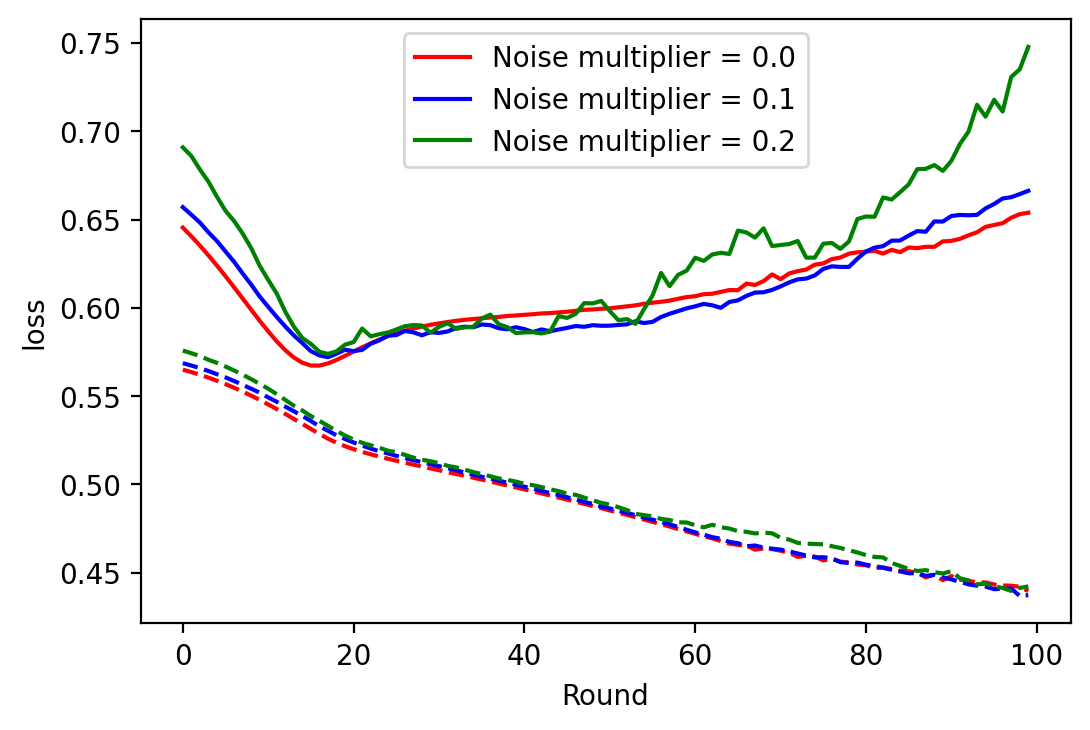

In [99]:
plt.subplots(dpi=200)

plt.plot([r_0_0['eval'][i]['eval']['loss'] for i in range(len(r_0_0['eval']))], c='r', alpha=1, label='Noise multiplier = 0.0')
plt.plot([r_0_0['training'][i]['train']['loss'] for i in range(len(r_0_0['eval']))], c='r', ls='--', alpha=1, label=None)

plt.plot([r_0_1['eval'][i]['eval']['loss'] for i in range(len(r_0_1['eval']))], c='b', alpha=1, label='Noise multiplier = 0.1')
plt.plot([r_0_1['training'][i]['train']['loss'] for i in range(len(r_0_1['eval']))], c='b', ls='--', alpha=1)

plt.plot([r_0_2['eval'][i]['eval']['loss'] for i in range(len(r_0_2['eval']))], c='g', alpha=1, label='Noise multiplier = 0.2')
plt.plot([r_0_2['training'][i]['train']['loss'] for i in range(len(r_0_2['eval']))], c='g', ls='--', alpha=1)

#plt.plot([r_0_3['eval'][i]['eval']['loss'] for i in range(len(r_0_3['eval']))], c='orange', alpha=0.2)
#plt.plot([r_0_3['training'][i]['train']['loss'] for i in range(len(r_0_3['eval']))], c='orange', alpha=0.2)

plt.xlabel("Round")
plt.ylabel("loss")

plt.legend()

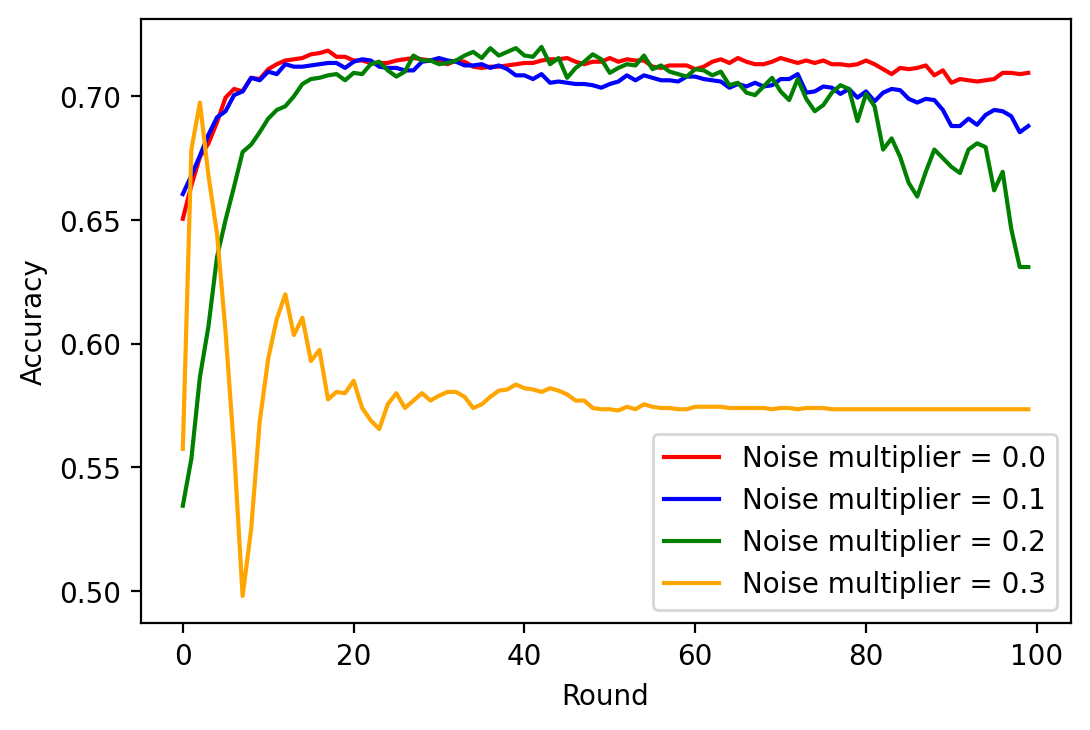

In [100]:
plt.subplots(dpi=200)

plt.plot([r_0_0['eval'][i]['eval']['binary_accuracy'] for i in range(len(r_0_0['eval']))], c='r', alpha=1, label='Noise multiplier = 0.0')
plt.plot([r_0_1['eval'][i]['eval']['binary_accuracy'] for i in range(len(r_0_1['eval']))], c='b', alpha=1, label='Noise multiplier = 0.1')
plt.plot([r_0_2['eval'][i]['eval']['binary_accuracy'] for i in range(len(r_0_2['eval']))], c='g', alpha=1, label='Noise multiplier = 0.2')
plt.plot([r_0_3['eval'][i]['eval']['binary_accuracy'] for i in range(len(r_0_3['eval']))], c='orange', alpha=1, label='Noise multiplier = 0.3')

plt.xlabel("Round")
plt.ylabel("Accuracy")
plt.legend()

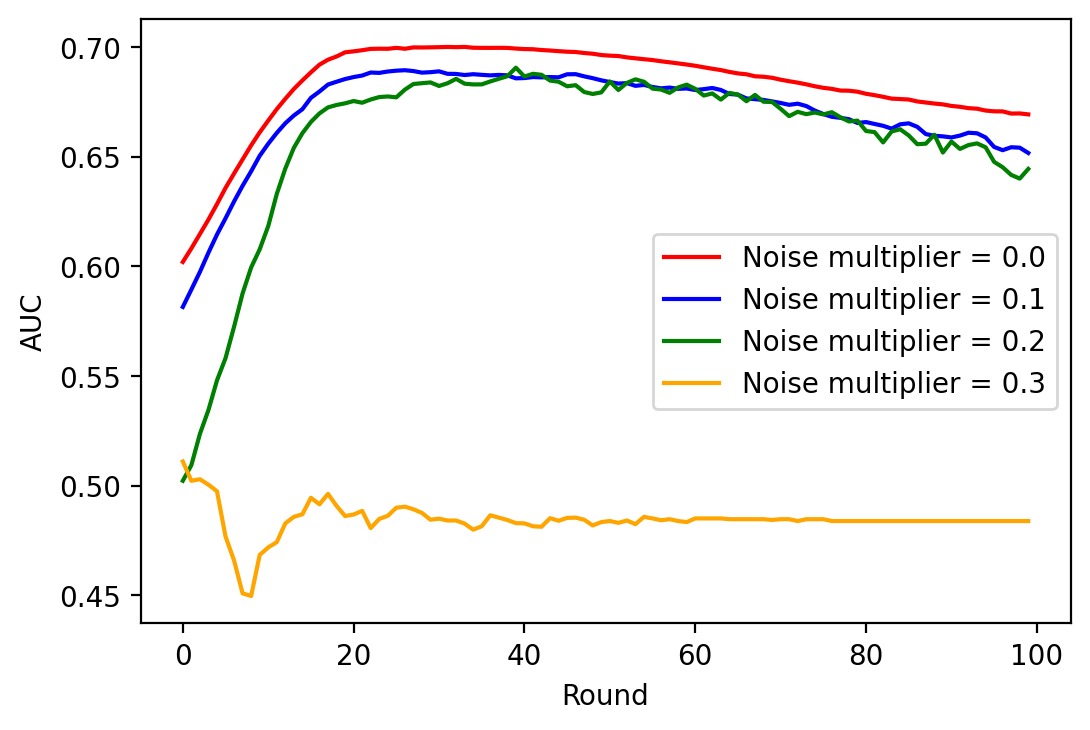

In [102]:
plt.subplots(dpi=200)

plt.plot([r_0_0['eval'][i]['eval']['AUC'] for i in range(len(r_0_0['eval']))], c='r', alpha=1, label='Noise multiplier = 0.0')
plt.plot([r_0_1['eval'][i]['eval']['AUC'] for i in range(len(r_0_1['eval']))], c='b', alpha=1, label='Noise multiplier = 0.1')
plt.plot([r_0_2['eval'][i]['eval']['AUC'] for i in range(len(r_0_2['eval']))], c='g', alpha=1, label='Noise multiplier = 0.2')
plt.plot([r_0_3['eval'][i]['eval']['AUC'] for i in range(len(r_0_3['eval']))], c='orange', alpha=1, label='Noise multiplier = 0.3')

plt.xlabel("Round")
plt.ylabel("AUC")

plt.legend()

In [59]:
km = create_keras_model()
km.compile(
      loss=tf.keras.losses.BinaryCrossentropy()
)

In [89]:
s = r_0_2['state'].model
s.assign_weights_to(km)

In [90]:
km.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 150)               15000     
                                                                 
 dense_1 (Dense)             (None, 50)                7550      
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 22,601
Trainable params: 22,601
Non-trainable params: 0
_________________________________________________________________


In [91]:
len(data[data.hospital_id.isin([1,2,3])]),len(data[data.hospital_id.isin([4])])

(6000, 2000)

In [92]:
%%time
loss_train = []
for idx, row in data[data.hospital_id.isin([1,2,3])].sample(6000).iterrows():
    X = np.array(row.features).reshape((1,99))
    y = np.array(row.target).reshape((1,1))
    
    loss = km.evaluate(X,y, verbose=0)
    loss_train.append(loss)

CPU times: user 5min 46s, sys: 26.7 s, total: 6min 13s
Wall time: 5min 45s


In [93]:
%%time
loss_test = []
for idx, row in data[data.hospital_id.isin([4])].sample(2000).iterrows():
    X = np.array(row.features).reshape((1,99))
    y = np.array(row.target).reshape((1,1))
    
    loss = km.evaluate(X,y, verbose=0)
    loss_test.append(loss)

CPU times: user 1min 54s, sys: 8.9 s, total: 2min 3s
Wall time: 1min 54s


In [94]:
attack_types = [
    AttackType.THRESHOLD_ATTACK,
    AttackType.LOGISTIC_REGRESSION,
    AttackType.MULTI_LAYERED_PERCEPTRON,
    AttackType.RANDOM_FOREST,
    AttackType.K_NEAREST_NEIGHBORS,
]

attacks_result = mia.run_attacks(
    AttackInputData(
        loss_train = np.array(loss_train),
        loss_test = np.array(loss_test),
    ),
    attack_types=attack_types
)

In [95]:
print(attacks_result.summary())

Best-performing attacks over all slices
  LOGISTIC_REGRESSION (with 2000 training and 2000 test examples) achieved an AUC of 0.59 on slice Entire dataset
  LOGISTIC_REGRESSION (with 2000 training and 2000 test examples) achieved an advantage of 0.16 on slice Entire dataset


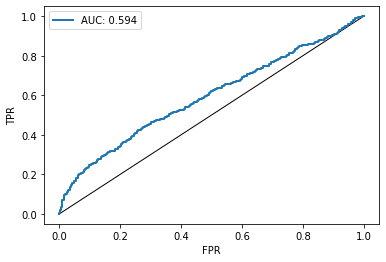

In [96]:
import tensorflow_privacy.privacy.privacy_tests.membership_inference_attack.plotting as plotting

max_auc_attacker = attacks_result.get_result_with_max_auc()
figure = plotting.plot_roc_curve(max_auc_attacker.roc_curve)